In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Step 1: Load Datasets
print("Loading datasets...")
measurement_summary_path = "https://raw.githubusercontent.com/Ritwik2412kolan/ML-Project/refs/heads/main/AirPollutionSeoul/Measurement_summary.csv"
measurement_info_path = "https://raw.githubusercontent.com/Ritwik2412kolan/ML-Project/refs/heads/main/AirPollutionSeoul/Original%20Data/Measurement_info.csv"
item_info_path = "https://raw.githubusercontent.com/Ritwik2412kolan/ML-Project/refs/heads/main/AirPollutionSeoul/Original%20Data/Measurement_item_info.csv"
station_info_path = "https://raw.githubusercontent.com/Ritwik2412kolan/ML-Project/refs/heads/main/AirPollutionSeoul/Original%20Data/Measurement_station_info.csv"

measurement_summary = pd.read_csv(measurement_summary_path)
measurement_info = pd.read_csv(measurement_info_path)
item_info = pd.read_csv(item_info_path)
station_info = pd.read_csv(station_info_path)

print("Datasets loaded successfully.")

Loading datasets...
Datasets loaded successfully.


In [ ]:
# Step 2: Data Cleaning and Preparation
print("Cleaning and preparing data...")
measurement_summary['Measurement date'] = pd.to_datetime(
    measurement_summary['Measurement date'], dayfirst=True, errors='coerce'
)
measurement_summary.dropna(subset=['Measurement date'], inplace=True)

# Merge datasets for analysis
merged_data = pd.merge(measurement_summary, station_info, on="Station code")
merged_data = pd.merge(merged_data, item_info, how="left", left_on="SO2", right_on="Item code")
merged_data.dropna(axis=1, how='all', inplace=True)

# Ensure proper indexing
merged_data['Measurement date'] = pd.to_datetime(merged_data['Measurement date'])
merged_data.set_index('Measurement date', inplace=True)

print("Data cleaning completed.")

Cleaning and preparing data...
Data cleaning completed.


<ipython-input-3-44a6ad2d0340>:10: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_data = pd.merge(merged_data, item_info, how="left", left_on="SO2", right_on="Item code")


Performing Exploratory Data Analysis...


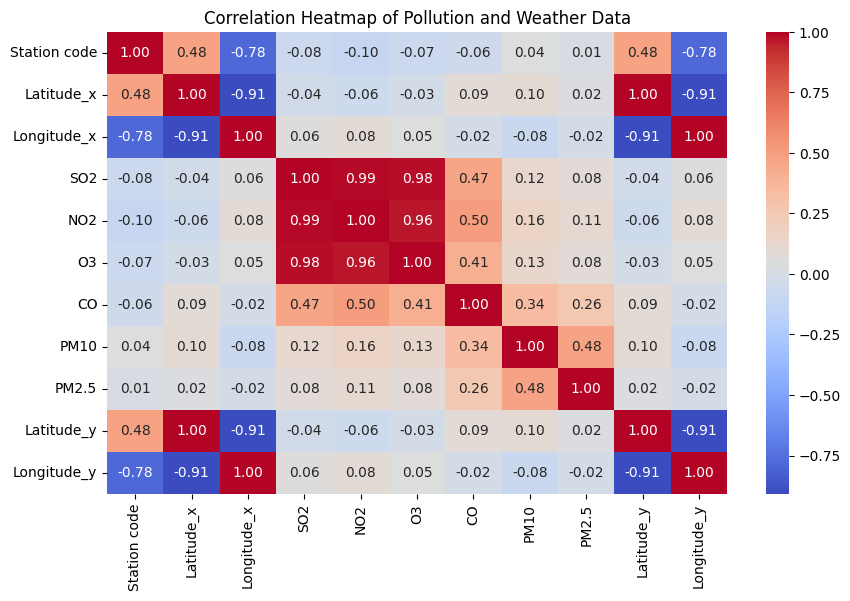

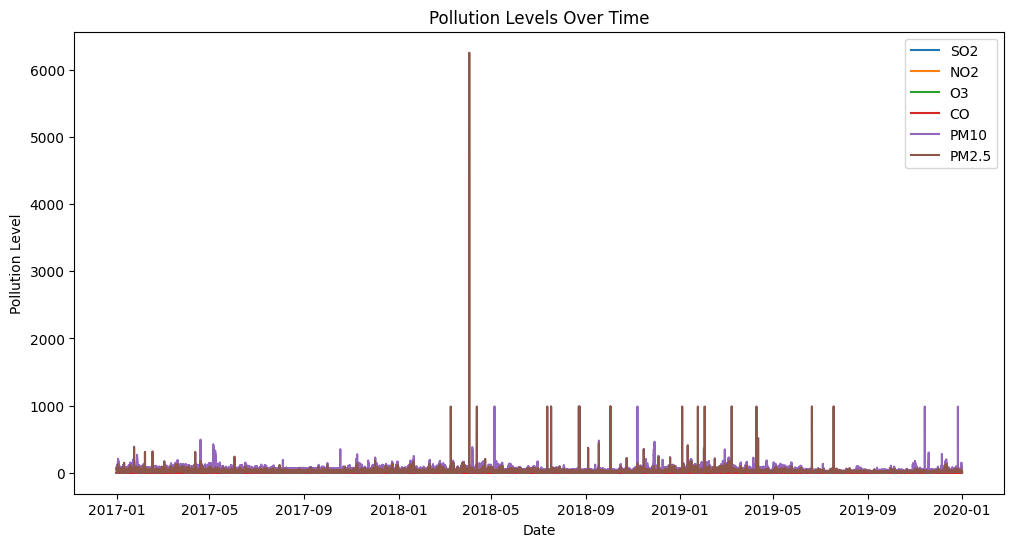

In [ ]:
# Step 3: Exploratory Data Analysis
print("Performing Exploratory Data Analysis...")
numeric_data = merged_data.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Pollution and Weather Data")
plt.show()

# Time series plot
plt.figure(figsize=(12, 6))
for pollutant in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']:
    if pollutant in measurement_summary.columns:
        plt.plot(measurement_summary['Measurement date'], measurement_summary[pollutant], label=pollutant)
plt.legend()
plt.title("Pollution Levels Over Time")
plt.xlabel("Date")
plt.ylabel("Pollution Level")
plt.show()

Performing clustering analysis and silhouette comparison...
Silhouette Score for k=2: 0.83
Silhouette Score for k=3: 0.92
Silhouette Score for k=4: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score for k=5: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score for k=6: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score for k=7: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score for k=8: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score for k=9: 1.00


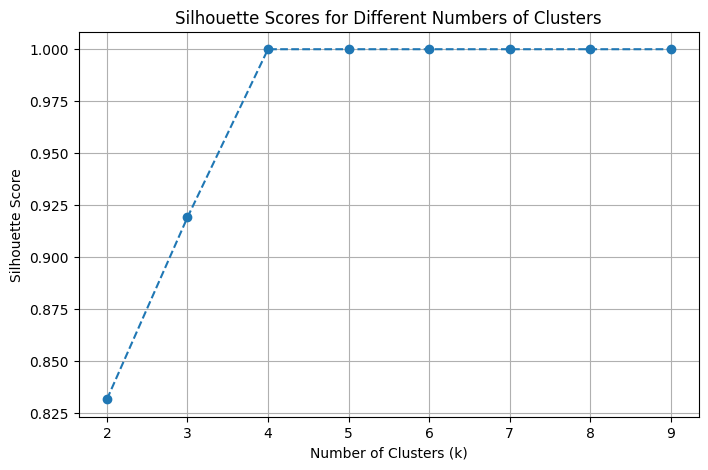

Optimal number of clusters based on silhouette score: 4
Silhouette Score for optimal k=4: 1.00


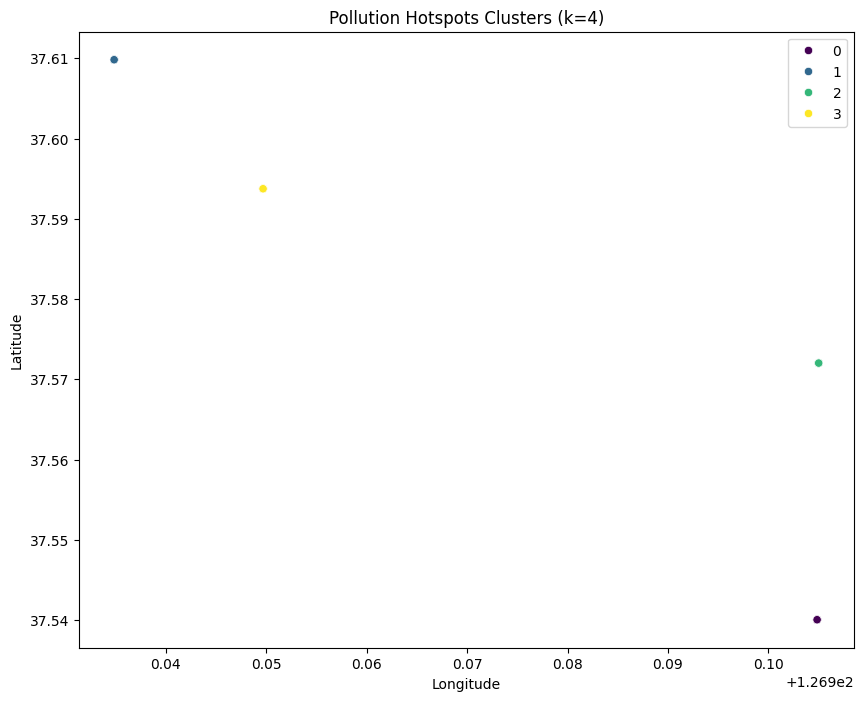

In [ ]:
# Step 4: Clustering - Identifying Pollution Hotspots
print("Performing clustering analysis and silhouette comparison...")
if 'Latitude' in measurement_summary.columns and 'Longitude' in measurement_summary.columns:
    # Prepare clustering data
    clustering_data = measurement_summary[['Latitude', 'Longitude', 'SO2', 'NO2', 'O3', 'PM10', 'PM2.5']].dropna()

    # Perform Silhouette Comparison for Different Values of k
    from sklearn.metrics import silhouette_score
    silhouette_scores = []
    cluster_range = range(2, 10)  # Test cluster sizes from 2 to 9

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        clustering_data['Cluster'] = kmeans.fit_predict(clustering_data[['Latitude', 'Longitude']])
        score = silhouette_score(clustering_data[['Latitude', 'Longitude']], clustering_data['Cluster'])
        silhouette_scores.append(score)
        print(f"Silhouette Score for k={k}: {score:.2f}")

    # Plot Silhouette Scores
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
    plt.title("Silhouette Scores for Different Numbers of Clusters")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.xticks(cluster_range)
    plt.grid()
    plt.show()

    # Choose the best k based on silhouette scores
    optimal_k = cluster_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

    # Perform KMeans clustering with the optimal number of clusters
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
    clustering_data['Cluster'] = kmeans_optimal.fit_predict(clustering_data[['Latitude', 'Longitude']])

    # Calculate and print Silhouette Score for optimal k
    silhouette_avg = silhouette_score(
        clustering_data[['Latitude', 'Longitude']], clustering_data['Cluster']
    )
    print(f"Silhouette Score for optimal k={optimal_k}: {silhouette_avg:.2f}")

    # Visualize Optimal Clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="Longitude", y="Latitude", hue="Cluster", data=clustering_data, palette="viridis"
    )
    plt.title(f"Pollution Hotspots Clusters (k={optimal_k})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()
else:
    print("Error: 'Latitude' and 'Longitude' columns are missing.")

In [ ]:
# Step 5: Prepare Data for LSTM
print("Preparing data for LSTM model...")
scaler = MinMaxScaler()
pollution_data = merged_data[['PM2.5']].dropna()
scaled_data = scaler.fit_transform(pollution_data)

# Creating sequences for LSTM
time_step = 30
X, y = [], []
for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i-time_step:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Preparing data for LSTM model...


In [ ]:
# Step 6: Build and Train LSTM Model
print("Building and training LSTM model...")
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(time_step, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Building and training LSTM model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2210/2210 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.0124 - loss: 1.2012e-05
Epoch 2/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.0135 - loss: 1.2595e-05
Epoch 3/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.0128 - loss: 3.4466e-05
Epoch 4/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.0131 - loss: 3.9341e-05
Epoch 5/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.0124 - loss: 2.2261e-05
Epoch 6/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.0130 - loss: 1.2770e-05
Epoch 7/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.0133 - loss: 8.0887e-06
Epoch 8/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.0130 - loss: 1.6352e-05
Epoch 9/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.0131 - loss: 1.2367e-05
Epoch 10/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.0129 - loss: 2.5205e-05
Epoch 11/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0

Training Accuracy: 1.29%
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
R-squared (Accuracy) for Test Set: 43.40%


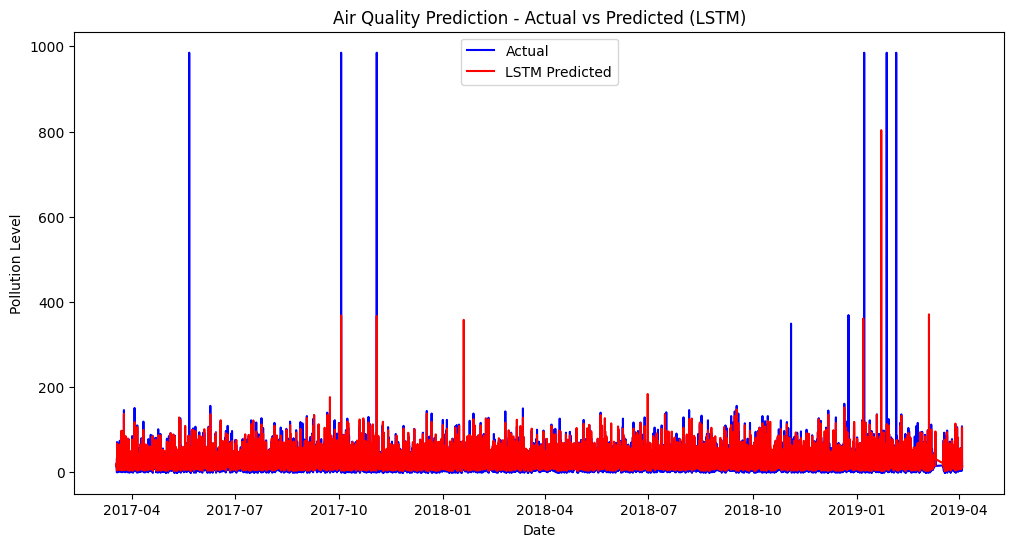

In [ ]:
# Step 7: Evaluate LSTM Model
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# Predictions and evaluation
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_test_actual, predicted_values)
print(f"R-squared (Accuracy) for Test Set: {r2*100:.2f}%")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(pollution_data.index[-len(y_test_actual):], y_test_actual, label="Actual", color="blue")
plt.plot(pollution_data.index[-len(y_test_actual):], predicted_values, label="LSTM Predicted", color="red")
plt.title("Air Quality Prediction - Actual vs Predicted (LSTM)")
plt.xlabel("Date")
plt.ylabel("Pollution Level")
plt.legend()
plt.show()